In [1]:
import numpy as np
import matplotlib.pyplot as plt
# from matplotlib import cm as colormaps
from scipy import interpolate

from importlib import reload

import environment as Env
import ray as Ray
import simulation as Sim

from topography import bathymetry as Bathy

In [2]:
reload(Bathy)

map_path = 'src/asc/MNT_MED100m_GDL-CA_HOMONIM_WGS84_NM_ZNEG.asc'
map = Bathy.Map.from_asc(map_path)

In [3]:
start = (2.8995, 41.6995)  # lower left
stop = (7.9005, 41.6995)  # lower right

x, z = map.cut(start, stop, npoints=100)
floor = interpolate.interp1d(x, z)

ceiling = lambda x: 0 * np.ones_like(x)

In [7]:
reload(Ray)
reload(Env)
reload(Sim)

source = np.array([0., 0.])
target = np.array([3500, -1000])

env = Env.Environment2D (floor, ceiling)
sim = Sim.EigenraySim2D (env, source, target, dx_max=50, dz_max=25, backprop=False, n_rebounds_max=6, n_rays_scan=1000, scan_angle_min=-1.5, scan_angle_max=1.5, verbose=True, verbose_depth_max=0)

Scanning using 1000 rays between angles -1.5 and 1.5


In [ ]:
sim.refine(n_rays=20, cone_half_angle=0.01)  # Initial refine (empirical: cone_half_angle = 10/n_rays_scan)
sim.refine(iterations=5)

	DEBUG: #1 - Floor rebound. New dir: [42.2658798  -4.87594944]
	DEBUG: Out of bounds (x-axis max)
	DEBUG: #1 - Floor rebound. New dir: [42.27847173 -4.86673767]
	DEBUG: Out of bounds (x-axis max)
	DEBUG: #1 - Floor rebound. New dir: [42.29108157 -4.85723726]
	DEBUG: Out of bounds (x-axis max)
	DEBUG: #1 - Floor rebound. New dir: [42.30370919 -4.84744604]
	DEBUG: Out of bounds (x-axis max)
	DEBUG: #1 - Floor rebound. New dir: [42.31635441 -4.83736179]
	DEBUG: Out of bounds (x-axis max)
	DEBUG: #1 - Floor rebound. New dir: [42.32901709 -4.82698227]
	DEBUG: Out of bounds (x-axis max)
	DEBUG: #1 - Floor rebound. New dir: [42.34169704 -4.81630523]
	DEBUG: Out of bounds (x-axis max)
	DEBUG: #1 - Floor rebound. New dir: [42.35439411 -4.80532839]
	DEBUG: Out of bounds (x-axis max)
	DEBUG: #1 - Floor rebound. New dir: [42.3671081  -4.79404947]
	DEBUG: Out of bounds (x-axis max)
	DEBUG: #1 - Floor rebound. New dir: [42.37983884 -4.78246616]
	DEBUG: Out of bounds (x-axis max)
	DEBUG: #1 - Floor r

KeyboardInterrupt: 

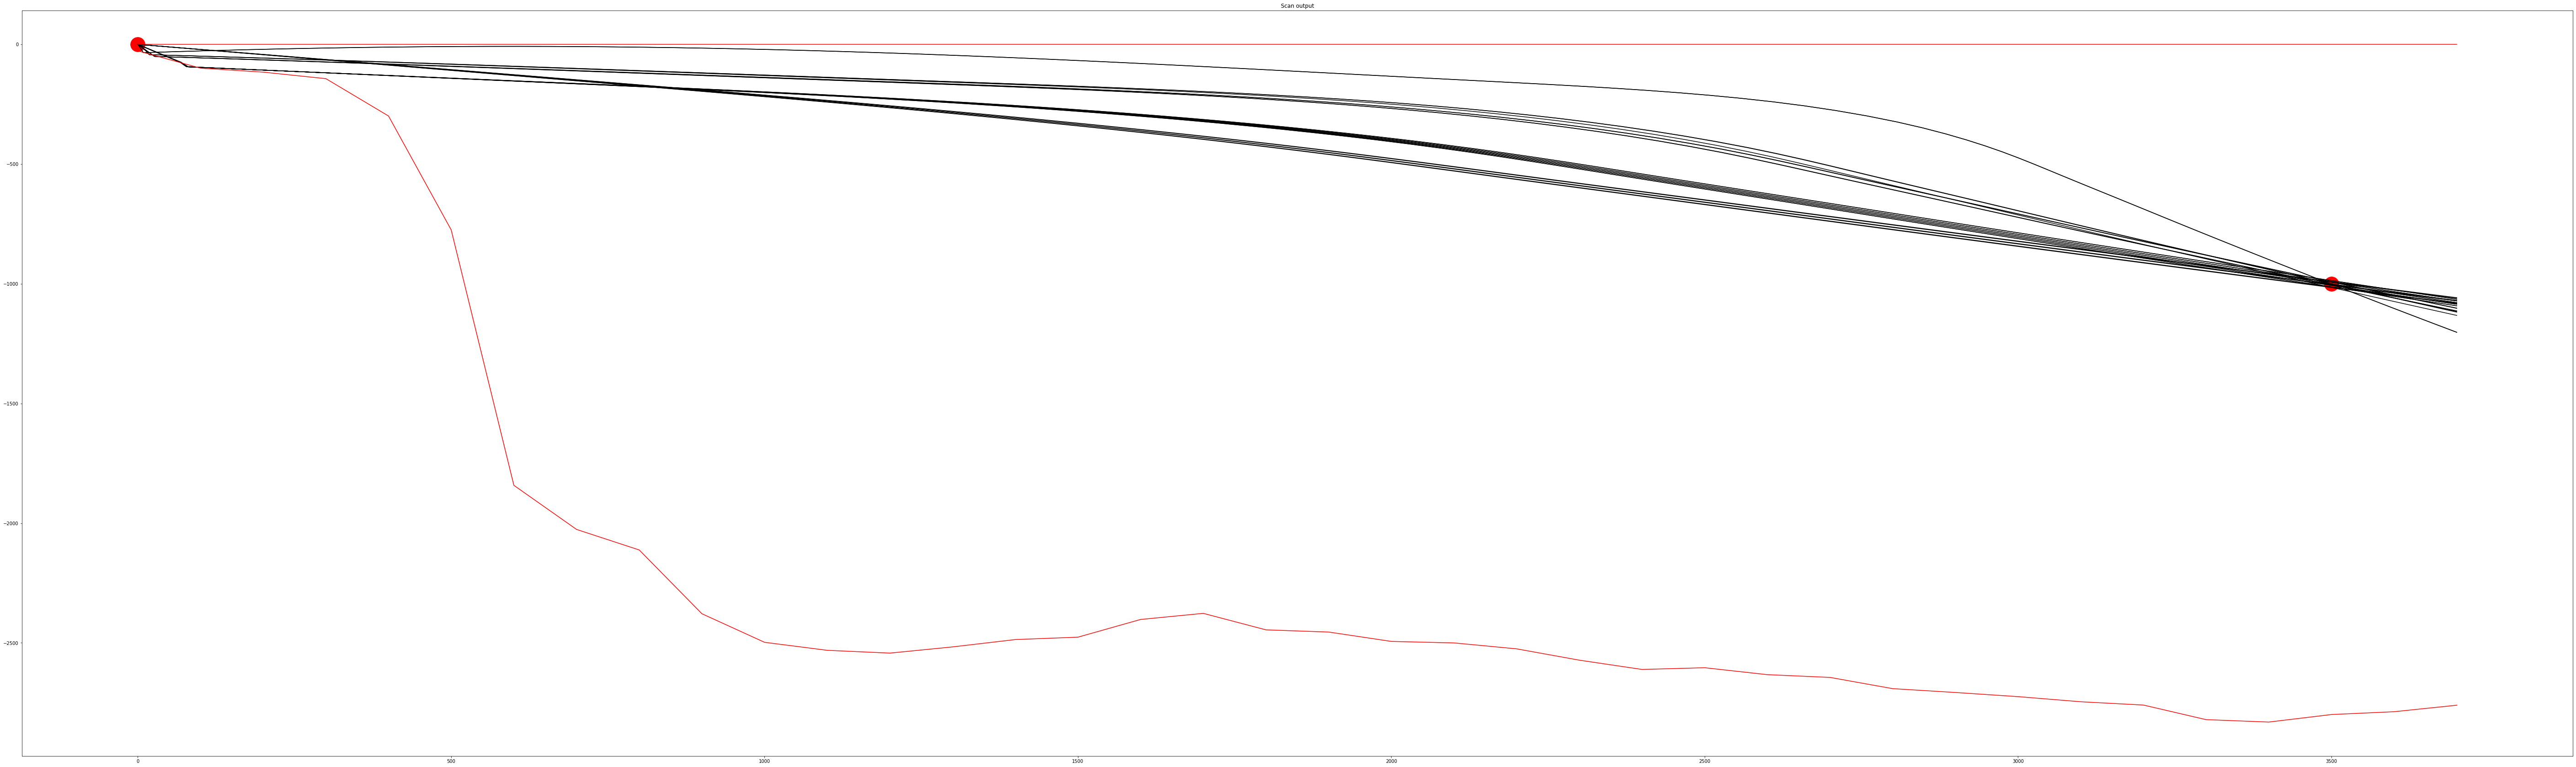

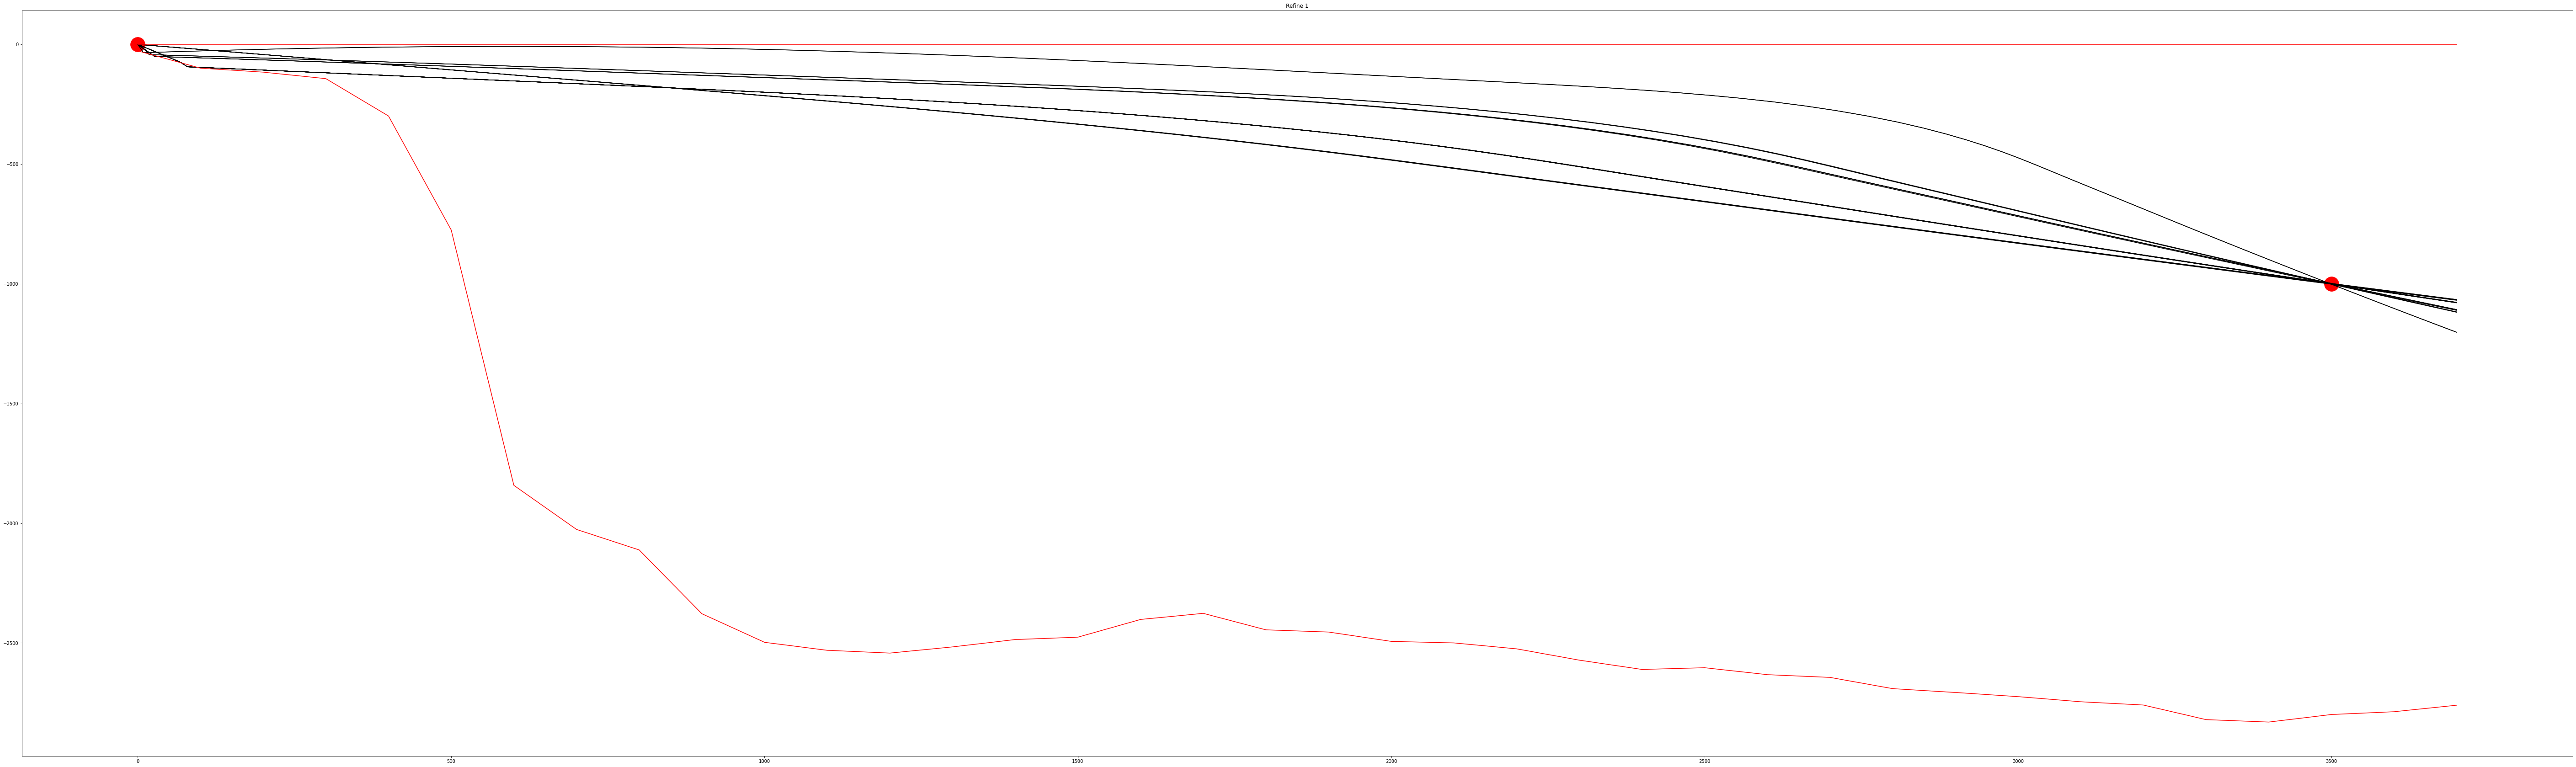

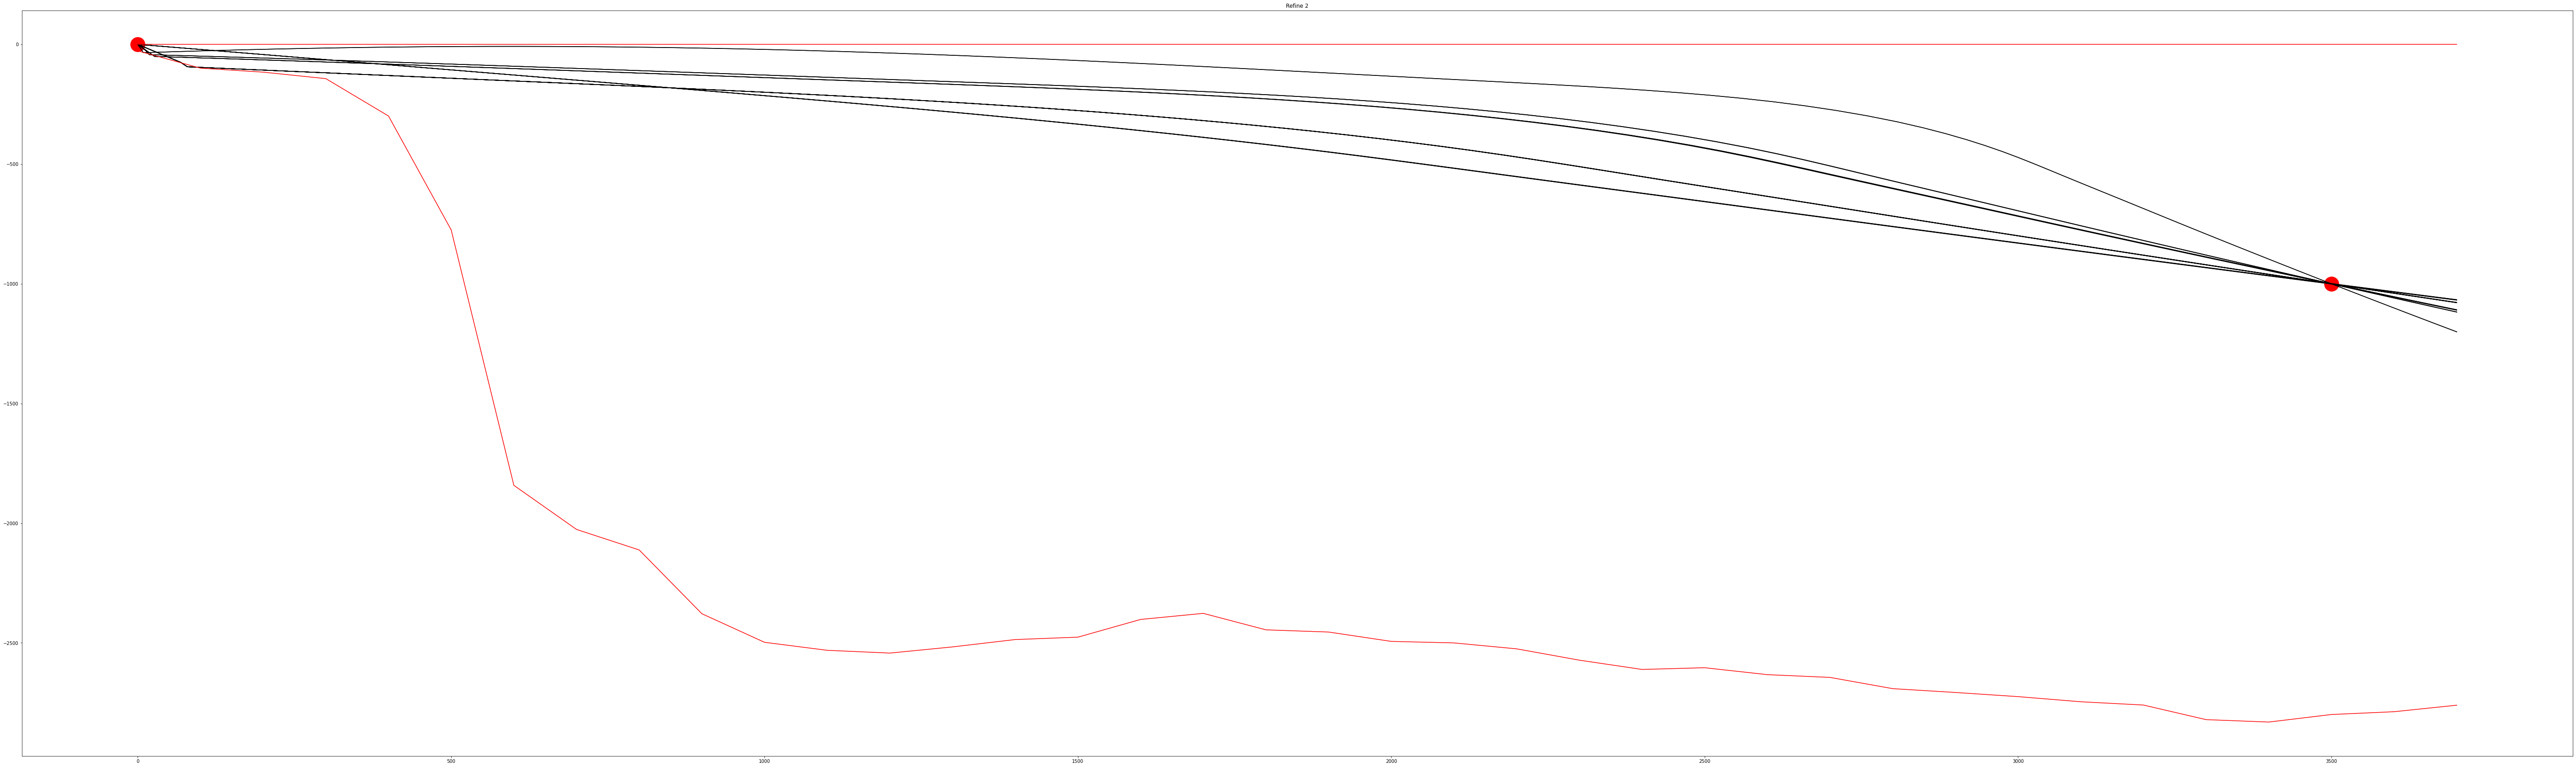

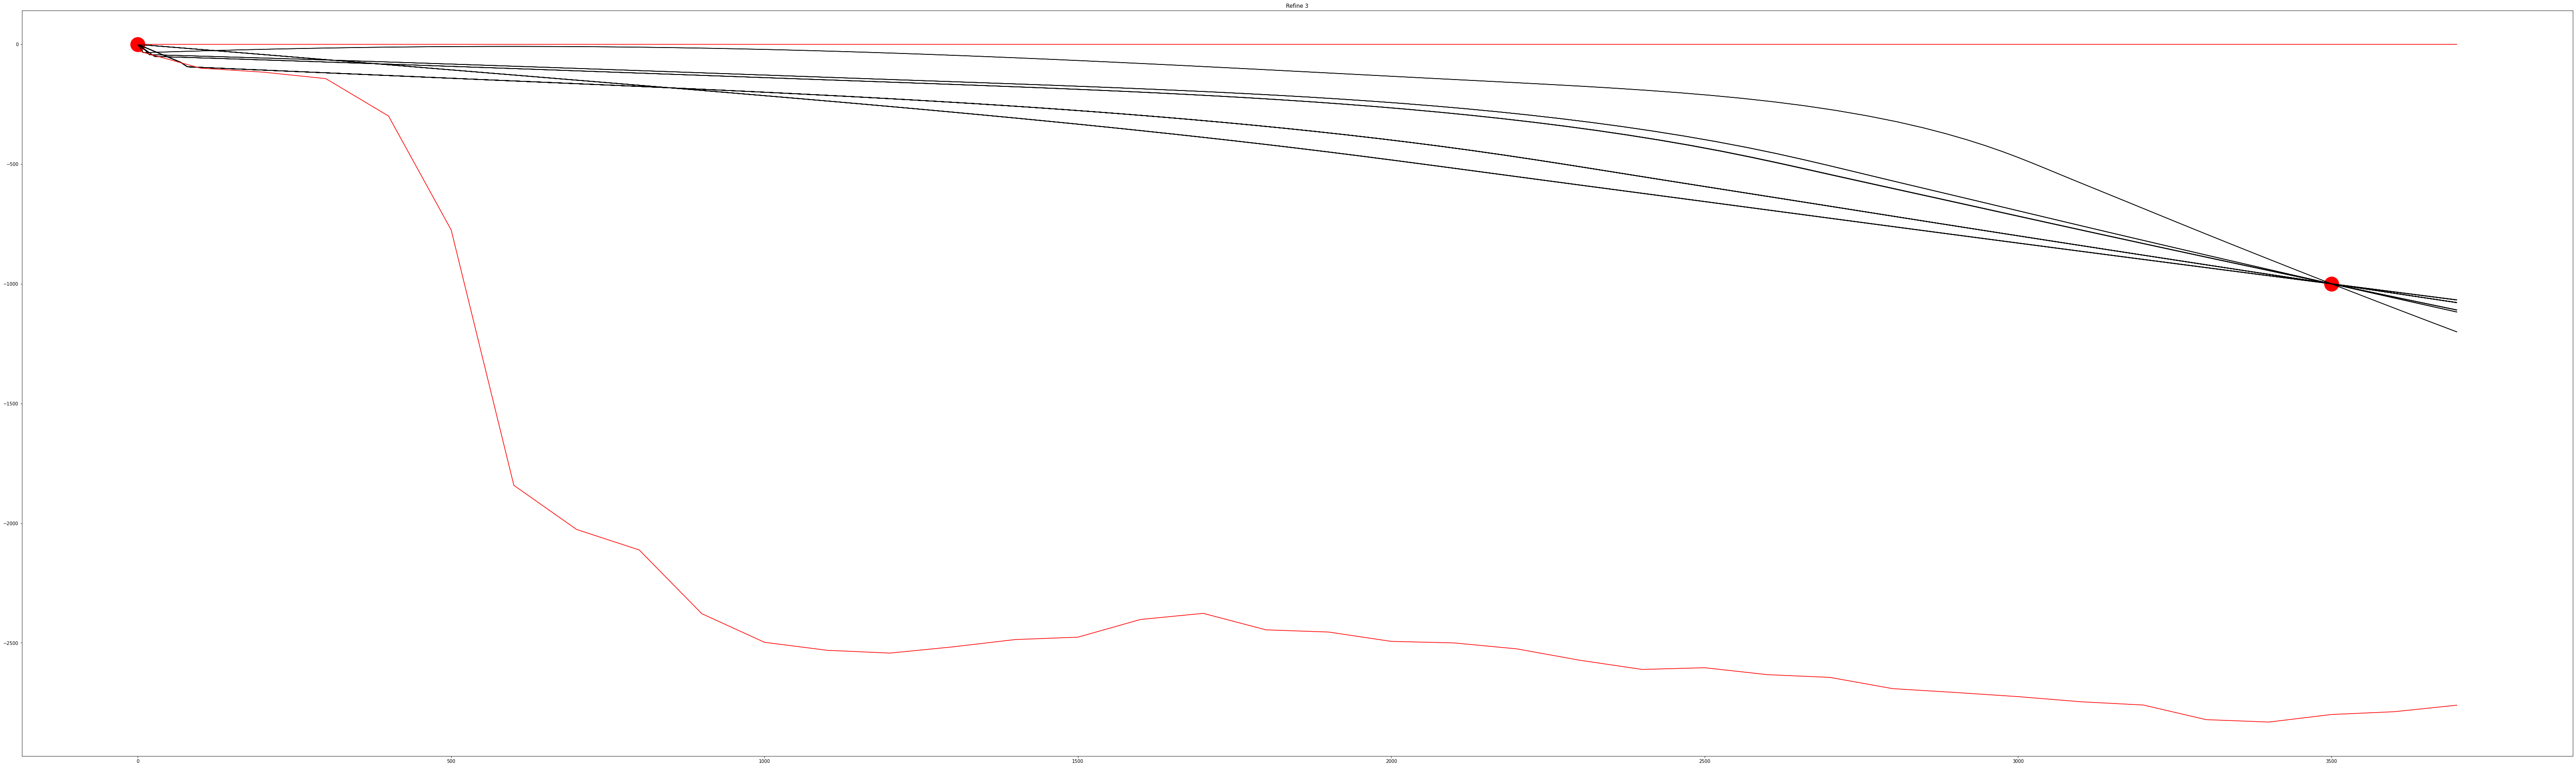

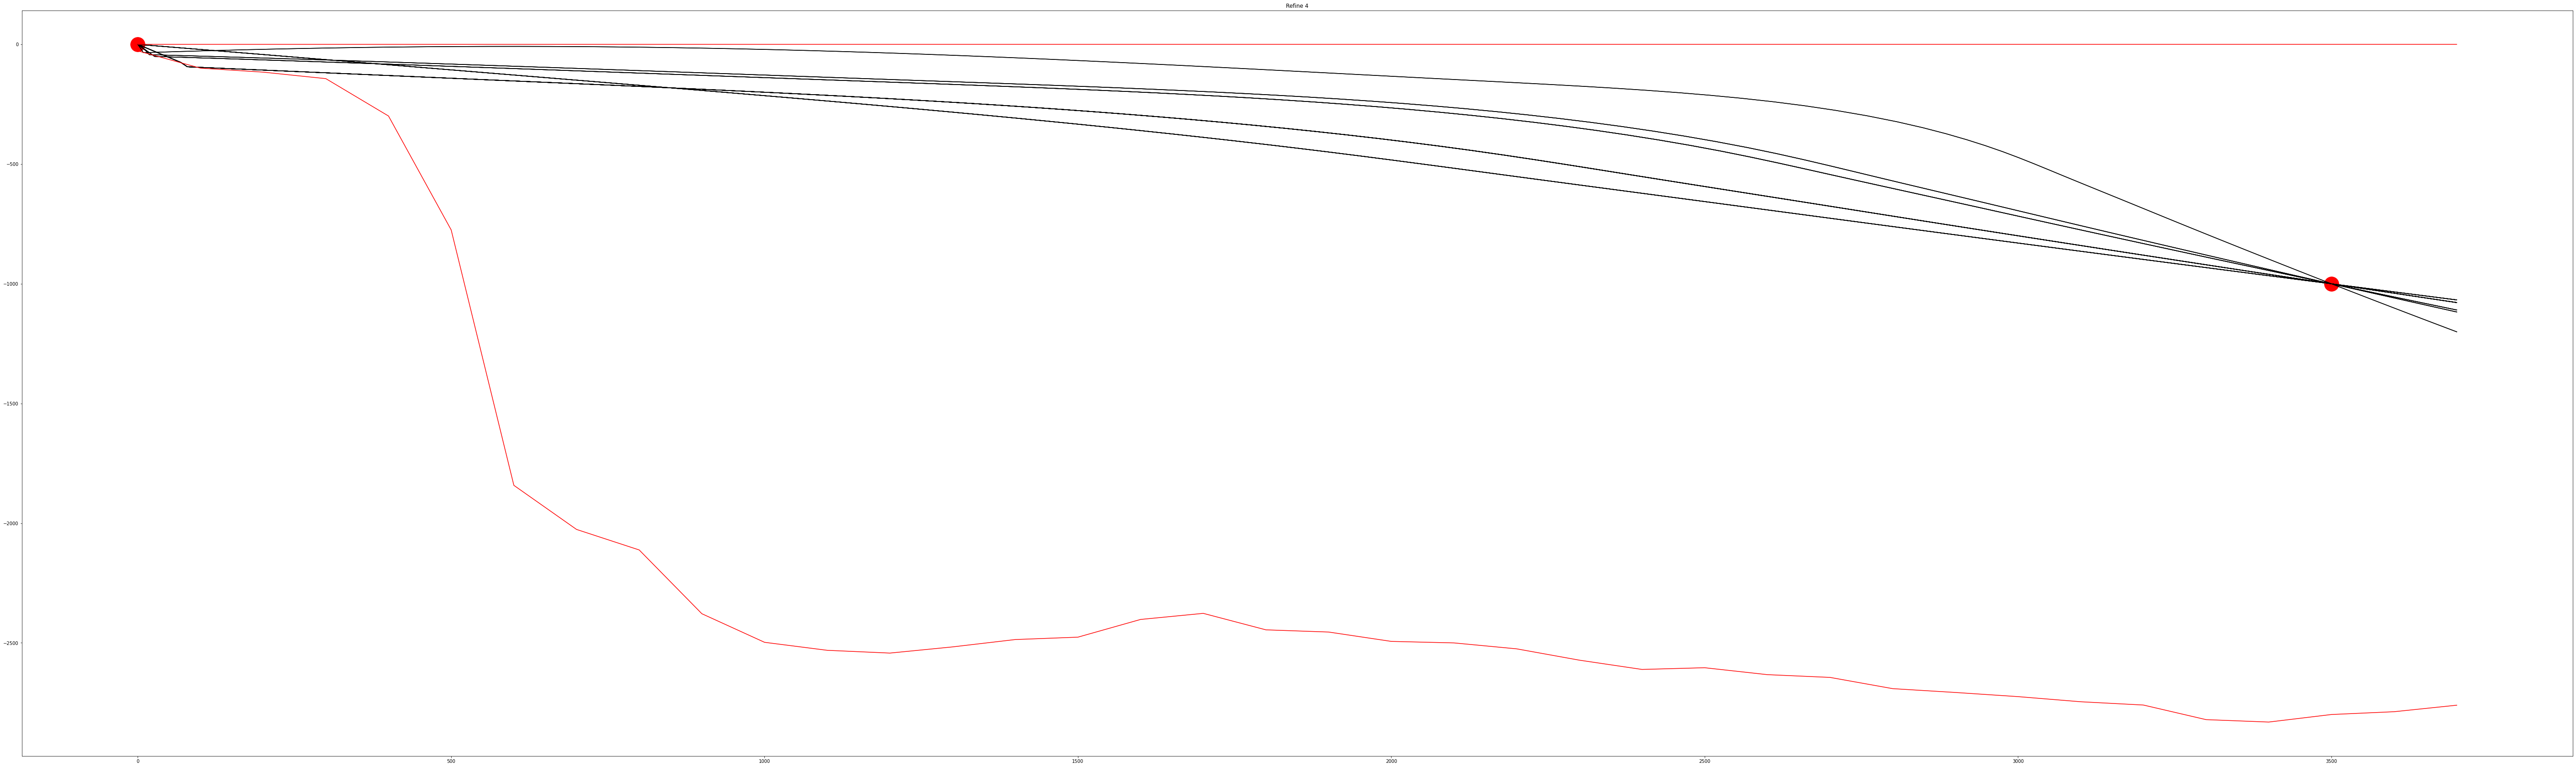

In [66]:
figsize = (100, 30)

# fig = plt.figure(figsize=figsize)
# sim.plot(fig, pack='__iter0-scan')
# plt.scatter((source[0], target[0]), (source[1], target[1]), figure=fig, c='red', s=1000)
# plt.title(f'Scanning rays')
# plt.show(fig)

fig = plt.figure(figsize=figsize)
sim.plot(fig, pack=sim.pack_scan, c='black')
plt.scatter((source[0], target[0]), (source[1], target[1]), figure=fig, c='red', s=1000)
plt.title(f'Scan output')
plt.show(fig)

for rid in range(1, sim.n_refines+1):
    fig = plt.figure(figsize=figsize)
    sim.plot(fig, pack=sim.gen_pack_refine(rid), c='black')
    plt.scatter((source[0], target[0]), (source[1], target[1]), figure=fig, c='red', s=1000)
    plt.title(f'Refine {rid}')
    plt.show(fig)


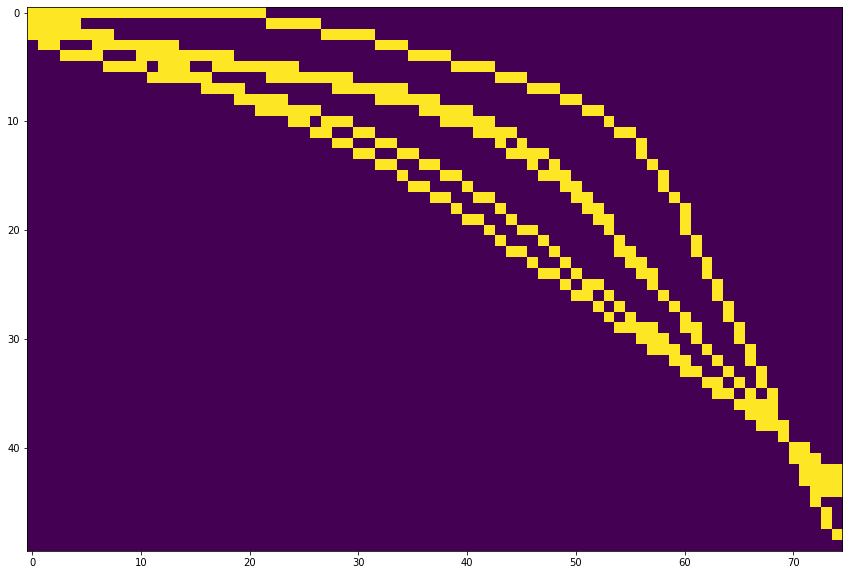

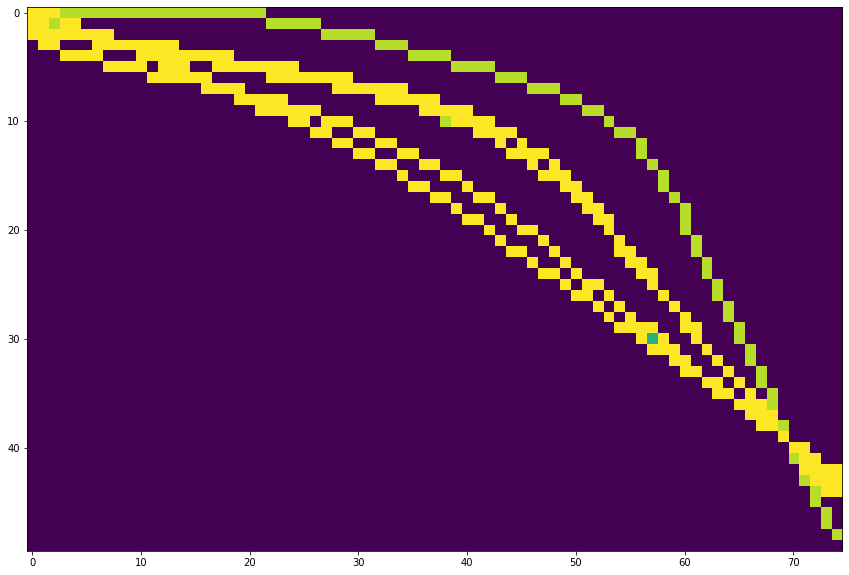

In [56]:
res = np.array([50, 25])

# Very sensitive
heatmap_plot_HI = sim.heatmap(resolution=res, reduction_power=.5, cutoff=.02)
plt.figure(figsize=(30, 10))
plt.imshow(heatmap_plot_HI)

# Less sensitive
heatmap_plot_LO = sim.heatmap(resolution=res, reduction_power=.5, cutoff=.1)
plt.figure(figsize=(30, 10))
plt.imshow(heatmap_plot_LO)

In [15]:
import cv2

heatmap_plot = heatmap_plot_LO

heatmap_plot_norm = (heatmap_plot - np.min(heatmap_plot)) / np.max(heatmap_plot)
heatmap_norm_3ch = np.tile(heatmap_plot_norm * 255, (3, 1, 1))
heatmap_norm_3ch = np.transpose(heatmap_norm_3ch, (1, 2, 0))

# cv2.imwrite('heatmap.jpg', heatmap_norm_3ch)

True

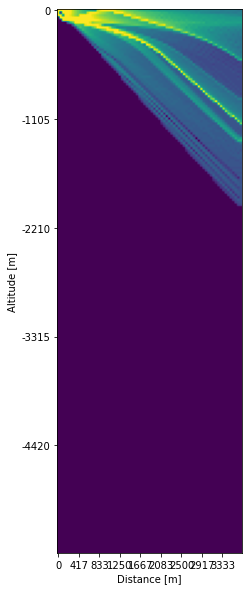

In [16]:
# TODO: add tickmarks
xdim, ydim = heatmap_plot.shape
plt.figure(figsize=(30, 10))

xticks_npoints = 10
yticks_npoints = 6
xticks_heatmap = np.linspace(0, ydim, xticks_npoints)
yticks_heatmap = np.linspace(0, xdim, yticks_npoints)
xticks_true = np.round(np.linspace(0, ydim, xticks_npoints) * res[0], 0) .astype(int)
yticks_true = np.round(np.linspace(0, xdim, yticks_npoints) * -1 * res[1], 0) .astype(int)
# TODO: Replace with clean arange

plt.xticks(xticks_heatmap, xticks_true)
plt.yticks(yticks_heatmap, yticks_true)
plt.xlabel('Distance [m]')
plt.ylabel('Altitude [m]')

plt.imshow(heatmap_plot)  # plt.imsave('heatmap.png', heatmap_plot.T)

In [17]:
# # Plot ground (convex assumption)
# z_floor = sim.env.floor(np.arange(0, ydim, 1) * res[0])  # floor samples
# z_width = np.arange(0, xdim, 1) * -1 * res[1]
# floor_mask = (np.tile(z_width, (ydim, 1)).T < z_floor).T

# floor_overlay = np.tile(floor_mask * 255, (3, 1, 1))
# floor_overlay = np.transpose(floor_overlay, (2, 1, 0))
# floor_overlay[:, :, 1:] = 0
# heatmap_norm_3ch += floor_overlay

# cv2.imwrite('heatmap-with-floor.jpg', heatmap_norm_3ch)
# cv2.imwrite('floor.jpg', floor_mask.T*255)